In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [2]:
pip install xgboost

In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import xgboost
from xgboost import XGBRegressor

#from google.colab import files

In [4]:
uploaded=files.upload()

Saving Crude Oil Prices Daily(final).xlsx to Crude Oil Prices Daily(final) (2).xlsx


In [5]:
data = pd.read_excel("Crude Oil Prices Daily(final).xlsx")
data

,Date,Closing Value
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87
...,...,...
9486,2023-09-12,88.87
9487,2023-09-13,88.59
9488,2023-09-14,90.13
9489,2023-09-15,90.83


##Data Exploration

In [6]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

In [7]:
data.set_index('Date', inplace=True)

In [8]:
data.index.year

Int64Index([1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986,
            ...
            2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023],
           dtype='int64', name='Date', length=9491)

In [9]:
data

,Closing Value
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87
...,...
2023-09-12,88.87
2023-09-13,88.59
2023-09-14,90.13


<Axes: xlabel='Date'>

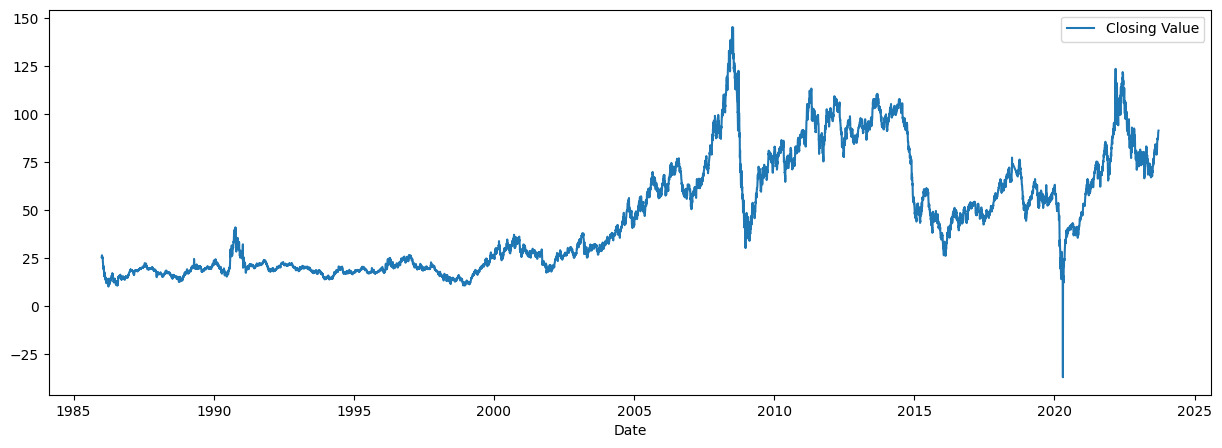

In [10]:
plt.figure(figsize=(15,5))
sns.lineplot(data)

In [11]:
# Checking Missing Values
data.isnull().sum()

Closing Value    7
dtype: int64

In [12]:
# Handling Missing Values
data['Closing Value'] = data['Closing Value'].interpolate()

In [13]:
data

,Closing Value
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87
...,...
2023-09-12,88.87
2023-09-13,88.59
2023-09-14,90.13


In [14]:
data.isnull().sum()

Closing Value    0
dtype: int64

In [15]:
# Renaming Column Name
data.rename(columns={'Closing Value': 'Price'}, inplace=True)
data

,Price
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87
...,...
2023-09-12,88.87
2023-09-13,88.59
2023-09-14,90.13


In [16]:
# Checking for Negative Value
(data['Price'] < 0).sum()

1

In [17]:
# Removing Negative Values
data['Price'] = data['Price'].apply(lambda x: x if x >= 0 else None)

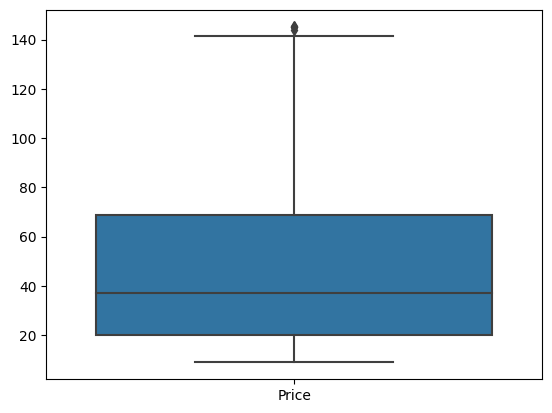

In [18]:
# Outliers
sns.boxplot(data)
plt.show()

In [19]:
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1
outliers = data[(data['Price'] < Q1 - 1.5 * IQR) | (data['Price'] > Q3 + 1.5 * IQR)]

In [20]:
# Outliers
outliers

,Price
Date,
2008-07-02,143.74
2008-07-03,145.31
2008-07-11,144.96
2008-07-14,145.16


In [21]:
def moving_average(data, window_size):
    return data['Price'].rolling(window=window_size, min_periods=1).mean()

In [22]:
window_size = 7  # Adjust the window size as needed
data['Moving_Avg'] = moving_average(data, window_size)

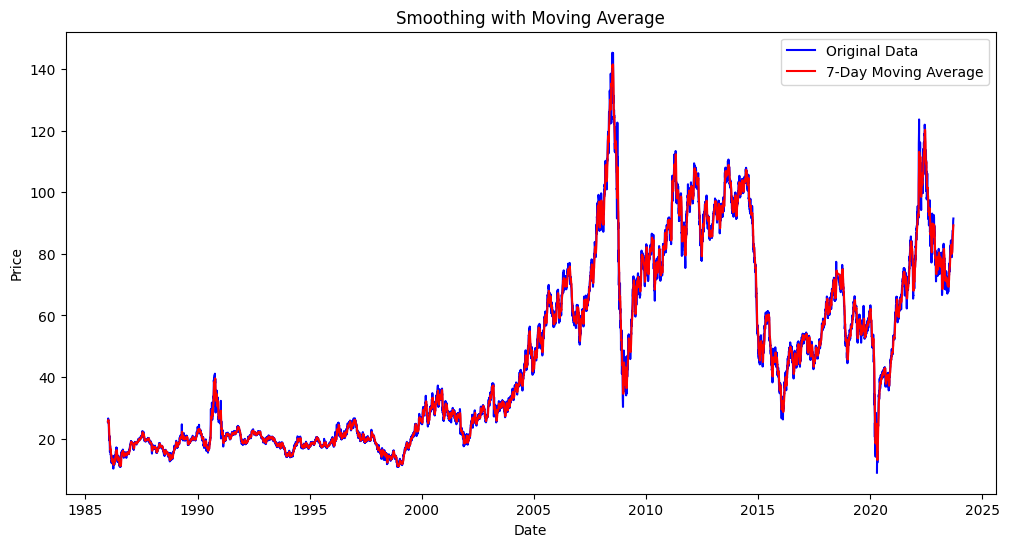

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(data['Price'], label='Original Data', color='blue')
plt.plot(data['Moving_Avg'], label=f'{window_size}-Day Moving Average', color='red')
plt.title('Smoothing with Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [24]:
data

,Price,Moving_Avg
Date,,
1986-01-02,25.56,25.560000
1986-01-03,26.00,25.780000
1986-01-06,26.53,26.030000
1986-01-07,25.85,25.985000
1986-01-08,25.87,25.962000
...,...,...
2023-09-12,88.87,87.194286
2023-09-13,88.59,87.632857
2023-09-14,90.13,88.117143


In [25]:
data.drop('Moving_Avg', axis = 1, inplace = True)

In [26]:
data

,Price
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87
...,...
2023-09-12,88.87
2023-09-13,88.59
2023-09-14,90.13


In [27]:
data.isnull().sum()

Price    1
dtype: int64

In [28]:
data.dropna(inplace = True)

In [29]:
data.isnull().sum()

Price    0
dtype: int64

# Stationarity

In [30]:
# Function to check stationarity and perform differencing
def check_stationarity(data):
    # Plot the time series
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Original Time Series')
    plt.title('Original Time Series')
    plt.show()

In [31]:
# Perform Dickey-Fuller test
result = adfuller(data, autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -2.262583549396987
p-value: 0.18431953384468192
Critical Values: {'1%': -3.431042104221526, '5%': -2.861845866939286, '10%': -2.5669328078740055}


In [32]:
# Check for stationarity
if result[1] <= 0.05:
    print('The time series is stationary.')
else:
    print('The time series is not stationary.')

The time series is not stationary.


In [33]:
# First-order differencing
data_diff = data.diff().dropna()

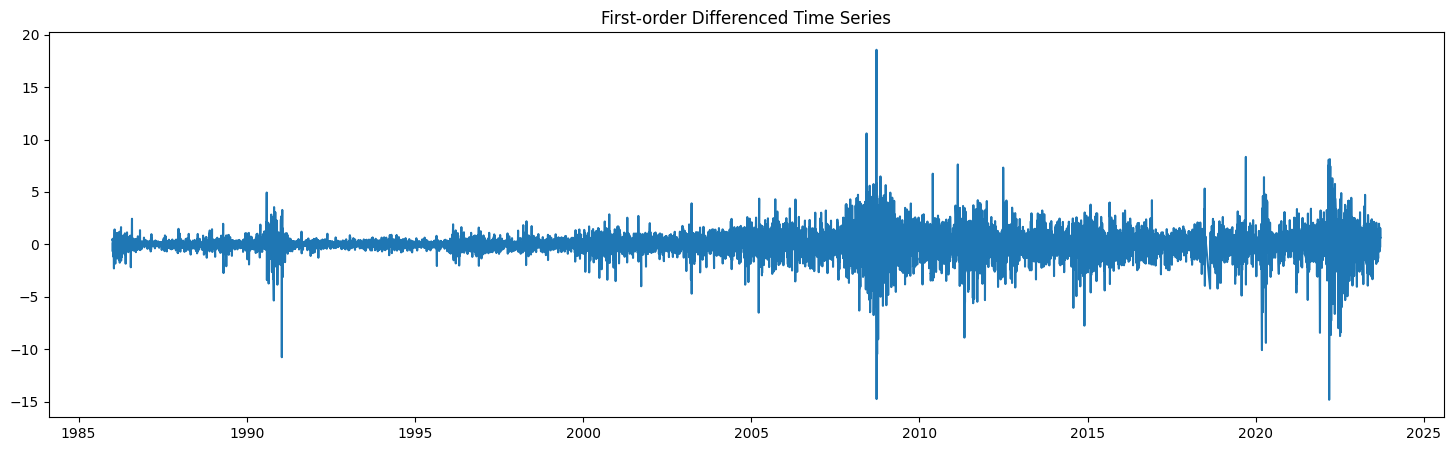

In [34]:
# Plot differenced time series
plt.figure(figsize=(18, 5))
plt.plot(data_diff, label='Differenced Time Series')
plt.title('First-order Differenced Time Series')
plt.show()

In [35]:
# Perform Dickey-Fuller test on differenced time series
result_diff = adfuller(data_diff, autolag='AIC')
print('ADF Statistic (after differencing):', result_diff[0])
print('p-value (after differencing):', result_diff[1])
print('Critical Values (after differencing):', result_diff[4])

ADF Statistic (after differencing): -13.083896506420738
p-value (after differencing): 1.8467159863507366e-24
Critical Values (after differencing): {'1%': -3.431042177479976, '5%': -2.8618458993111844, '10%': -2.56693282510568}


In [36]:
# Check for stationarity after differencing
if result_diff[1] <= 0.05:
    print('The differenced time series is stationary.')
else:
    print('Differencing did not make the time series stationary.')

The differenced time series is stationary.


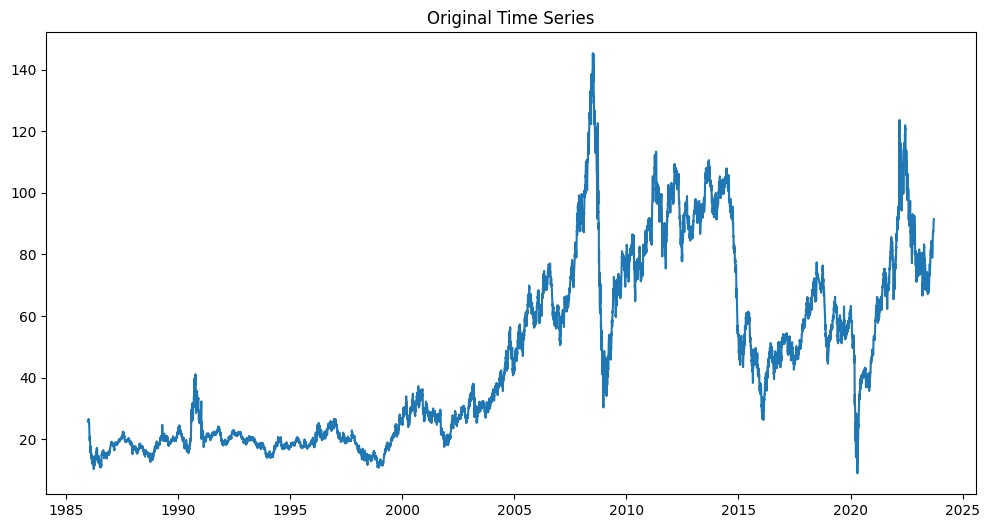

In [37]:
time_series = data['Price']

check_stationarity(time_series)

# Train and Split Data

In [38]:
# The percentage of data to be used for training and validation
train_percentage = 0.75
validation_percentage = 0.10

In [39]:
train_size = int(len(data) * train_percentage)
validation_size = int(len(data) * validation_percentage)

In [40]:
# Split the data
train_data = data[:train_size]
validation_data = data[train_size:train_size + validation_size]
test_data = data[train_size + validation_size:]

In [41]:
# Print the shapes of the training and testing sets
print("Training set shape:", train_data.shape)
print("Validation set shape:", validation_data.shape)
print("Testing set shape:", test_data.shape)

Training set shape: (7117, 1)
Validation set shape: (949, 1)
Testing set shape: (1424, 1)


In [42]:
data_values = data['Price'].values

In [43]:
your_seasonality = 12

# Holt-Winters method

In [44]:
# Create an ExponentialSmoothing model (Holt-Winters method)
model = ExponentialSmoothing(data_values, trend='add', seasonal='add', seasonal_periods=your_seasonality)

In [45]:
# Fit the model
fit_model = model.fit()

In [46]:
# Forecast future values
forecast = fit_model.forecast(steps=365)

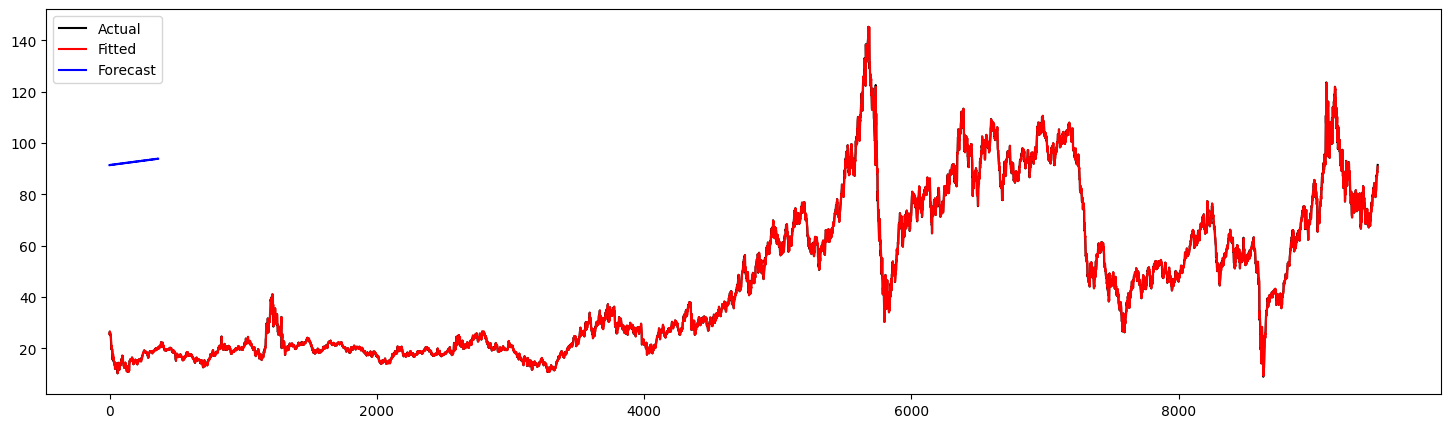

In [47]:
# Plot the original time series and the forecast
plt.figure(figsize=(18, 5))
plt.plot(data_values, label='Actual',color='black')
plt.plot(fit_model.fittedvalues, label='Fitted', color='red')
plt.plot(forecast, label='Forecast', color='blue')
plt.legend()
plt.show()

In [48]:
validation_forecast = fit_model.forecast(steps=len(validation_data))

In [49]:
mse = mean_squared_error(validation_data['Price'], validation_forecast)
print("Mean Squared Error on Validation Set:", mse)

Mean Squared Error on Validation Set: 1895.0963185837004


In [50]:
# Adjust smoothing parameters
new_alpha = 0.5
new_beta = 0.5
new_gamma = 0.5

In [51]:
# Train the model with adjusted parameters
new_fit_model = model.fit(smoothing_level=new_alpha, smoothing_slope=new_beta, smoothing_seasonal=new_gamma, optimized=False)

<ipython-input-51-bd32177e32b6>:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  new_fit_model = model.fit(smoothing_level=new_alpha, smoothing_slope=new_beta, smoothing_seasonal=new_gamma, optimized=False)


In [52]:
# Validate on the validation set again
new_validation_forecast = new_fit_model.forecast(steps=len(validation_data))

In [53]:
# Evaluate performance using RMSE
rmse = np.sqrt(mean_squared_error(validation_data['Price'], validation_forecast))
print("Root Mean Squared Error (RMSE) on Validation Set:", rmse)

Root Mean Squared Error (RMSE) on Validation Set: 43.53270401185413


In [54]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(validation_data['Price'], validation_forecast)
print("Mean Absolute Error (MAE) on Validation Set:", mae)

Mean Absolute Error (MAE) on Validation Set: 40.41107026401432


In [55]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(validation_data['Price'], validation_forecast)
print("Mean Absolute Percentage Error (MAPE) on Validation Set:", mape)

Mean Absolute Percentage Error (MAPE) on Validation Set: 86.51747655516934


# KNN

In [56]:
data_values = data['Price'].values

In [57]:
# Choosing the number of neighbors (k) and the lookback window size
k = 5
lookback_window = 10

In [58]:
# Prepare the feature matrix X and target variable y
X, y = [], []

In [59]:
for i in range(len(data_values) - lookback_window):
    X.append(data_values[i:i+lookback_window])
    y.append(data_values[i+lookback_window])

In [60]:
X, y = np.array(X), np.array(y)

In [61]:
# Scale the data (important for KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [62]:
# Initialize the KNN model
knn_model = KNeighborsRegressor(n_neighbors=k)

In [63]:
# Train the model
knn_model.fit(X_scaled, y)

KNeighborsRegressor()

In [64]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have an array 'actual_values' with the actual values for the previous and next 365 days

forecasted_values = []
actual_values = []  # Replace this with your actual data

# Assuming 'actual_values' already contains data for the previous 365 days
actual_values.extend(data_values[-365:])

for _ in range(365):
    # Use the last 'lookback_window' values as input for the next prediction
    last_window = data_values[-lookback_window:]
    last_window_scaled = scaler.transform(last_window.reshape(1, -1))

    # Make a one-step prediction
    next_pred = knn_model.predict(last_window_scaled)

    # Append the prediction to the forecasted values
    forecasted_values.append(next_pred[0])

    # Update the time series with the new prediction
    data_values = np.append(data_values, next_pred)

    # Assuming you have actual values for the next 365 days
    actual_value = actual_values.pop(0)  # Get the actual value for the current day
    actual_values.append(actual_value)  # Move to the next day

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, forecasted_values))
print(f'RMSE: {rmse}')


RMSE: 12.621817087341322


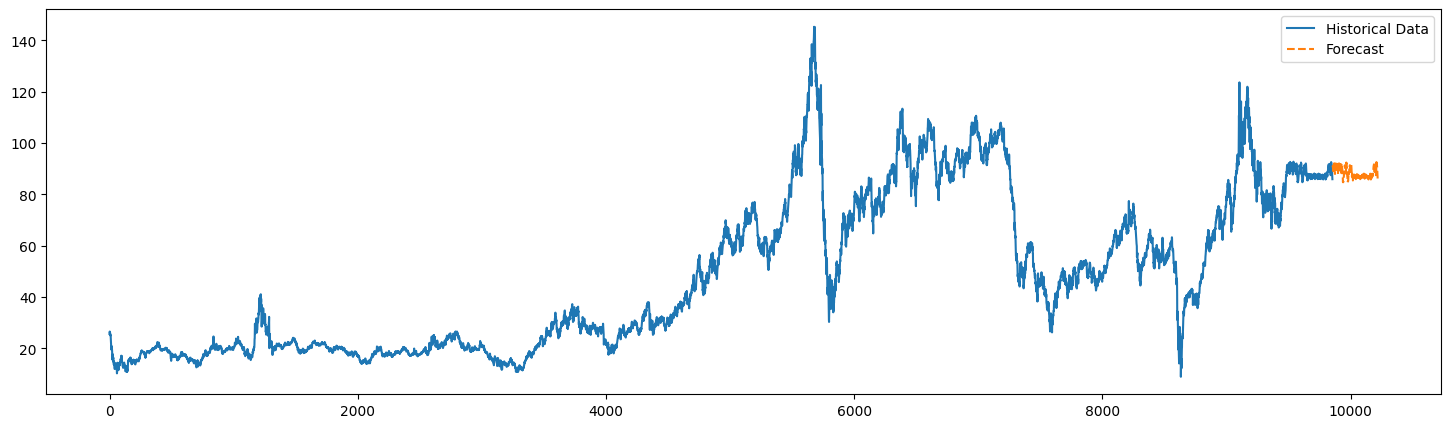

In [65]:
# Visualize the forecasted values
plt.figure(figsize=(18, 5))
plt.plot(data_values, label='Historical Data')
plt.plot(np.arange(len(data_values), len(data_values) + 365), forecasted_values, label='Forecast', linestyle='dashed')
plt.legend()
plt.show()

In [66]:
len(forecasted_values)

365

# Decision Tree

In [67]:
data_values = data['Price'].values

In [68]:
# Choose the lookback window size
lookback_window = 10

In [69]:
# Prepare the feature matrix X and target variable y
X, y = [], []

In [70]:
for i in range(len(data_values) - lookback_window):
    X.append(data_values[i:i+lookback_window])
    y.append(data_values[i+lookback_window])

In [71]:
X, y = np.array(X), np.array(y)

In [72]:
# Initialize the Decision Tree model
dt_model = DecisionTreeRegressor()

In [73]:
# Train the model
dt_model.fit(X, y)

DecisionTreeRegressor()

In [74]:
# Predict values for the next 365 days
forecasted_values = []
actual_values = []

In [75]:
# Assuming 'actual_values' already contains data for the previous 365 days
actual_values.extend(data_values[-365:])

In [76]:
# Use the last 'lookback_window' values as input for the next prediction
last_window = data_values[-lookback_window:]

for _ in range(365):
    # Make a one-step prediction
    next_pred = dt_model.predict([last_window])

    # Append the prediction to the forecasted values
    forecasted_values.append(next_pred[0])

    # Update the time series with the new prediction
    last_window = np.append(last_window[1:], next_pred)

    # Assuming you have actual values for the next 365 days
    actual_value = actual_values.pop(0)  # Get the actual value for the current day
    actual_values.append(actual_value)

In [77]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, forecasted_values))
print(f'RMSE: {rmse}')

RMSE: 21.056352875993415


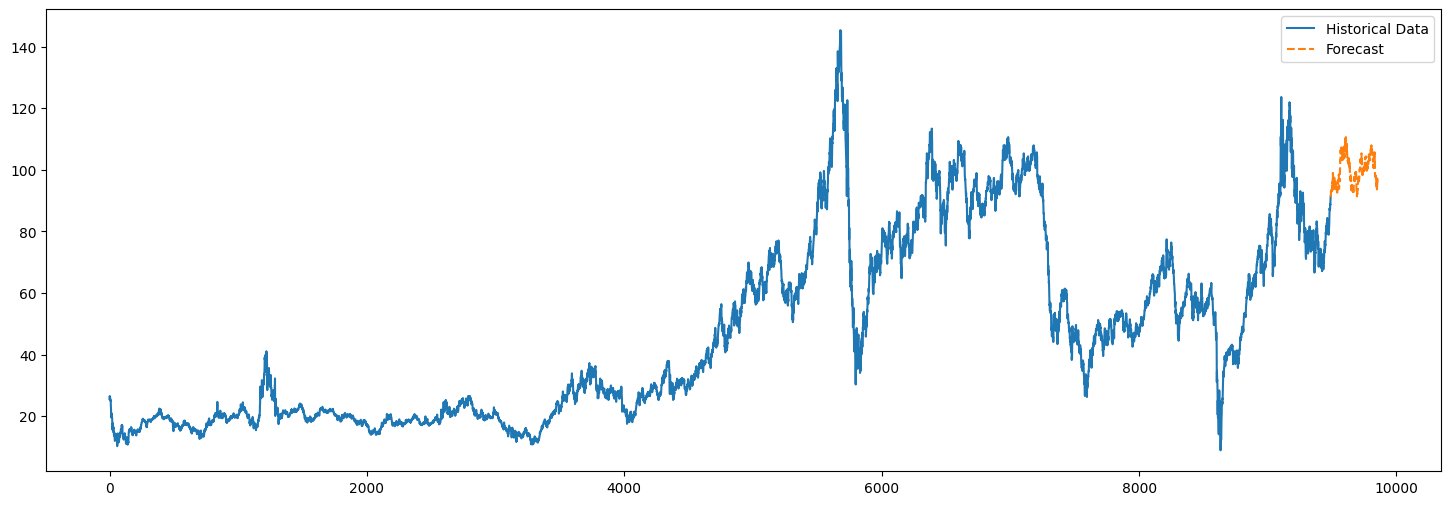

In [78]:
# Visualize the forecasted values
plt.figure(figsize=(18,6))
plt.plot(data_values, label='Historical Data')
plt.plot(np.arange(len(data_values), len(data_values) + 365), forecasted_values, label='Forecast', linestyle='dashed')
plt.legend()
plt.show()

# XG Boost

In [79]:
data_values = data['Price'].values

In [80]:
# Create lag features
def create_lag_features(data, lag):
    for i in range(1, lag + 1):
        data[f'lag_{i}'] = data['Price'].shift(i)
    return data.dropna()

In [81]:
# Choose the number of lag features
lag = 10
data_with_lags = create_lag_features(data, lag)

In [82]:
# Prepare the feature matrix X and target variable y
X = data_with_lags.drop('Price', axis=1)
y = data_with_lags['Price']

In [83]:
# Initialize the XGBoost model
xgb_model = XGBRegressor()

In [84]:
# Train the model on the entire dataset
xgb_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [85]:
# Predict values for the next 365 days
forecasted_values = []
actual_values = []

In [86]:
# Assuming 'actual_values' already contains data for the previous 365 days
actual_values.extend(data_values[-365:])

In [87]:
# Use the last 'lag' values as input for the next prediction
last_window = X.iloc[-1].values

for _ in range(365):
    # Make a one-step prediction
    next_pred = xgb_model.predict([last_window])

    # Append the prediction to the forecasted values
    forecasted_values.append(next_pred[0])

    # Update the input window with the new prediction
    last_window = np.append(last_window[1:], next_pred)

    # Assuming you have actual values for the next 365 days
    actual_value = actual_values.pop(0)
    actual_values.append(actual_value)

In [88]:
# Create datetime index for the forecasted period
forecast_index = pd.date_range(start=data.index[-1], periods=365, freq='D')[1:]

In [89]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, forecasted_values))
print(f'RMSE: {rmse}')

RMSE: 14.441997598302848
